# Example of Using Modelling Results to Find Optimal TGF Allocation


This is an example of how we can use the results from the models to find the "optimal" allocation of funds between countries in the portfolio.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint

np.random.seed(0)
num_countries = 8

### Define data structure for the database of model results

We create some dummy results and use a class 'DatabaseOfModelResults' to access them.

In [3]:
class DatabaseOfModelResults:
    """This represents the database of model results for a particular disease.
    It is interfaced using `get_results`. The rest of this class is just concerned with holding the results from
    different countries.
    """

    def __init__(self, _num_countries):
        self.country_results = dict()
        self.generate_country_results(_num_countries)

    def generate_country_results(self, _num_countries):
        """Create arbitrary set of data, representing the model results for each country."""

        for _c in range(num_countries):
            # Construct a set of 'model results' that conforms to our expectations of a curve of diminishing returns
            #  between budget and health_gain that begins at (0,0) and saturates. The chosen curve is an exponential
            #  function with two parameters: `coefficient` (rate of saturation) and `ceiling` the saturated value for
            #  health_gain.

            coefficient = np.random.exponential(0.03)
            ceiling = np.random.random_sample()

            budget_i = np.arange(0, 500, 1)
            health_i = ceiling * (1 - np.exp(-coefficient * budget_i))
            self.country_results[_c] = pd.Series(index=budget_i, data=health_i, name='health_gain').rename_axis('budget')


    def get_results(self, country: int, budget: float):
        """
        This is the main way of retrieving results from the database. For a given country and budget, the health impact
        is returned (interpolating where necessary).
        If a budget is less than the minimum reported in the result, the health_gain for the minimal budget is returned;
        If a budget is greater than the maximum reported in the results, the health gain for the maximum budget is
        returned.

        :param country: integer representing an index on the country code
        :param budget: budget that the country is allocated.
        :return: the health_gain (arbitrary units) is returned.
        """

        # retrieve results from database:
        assert country in self.country_results, 'country is not valid'
        country_results = self.country_results[country]

        # return the health_gain for the budget, using interpolation where necessary
        if budget >= max(country_results.index):
            return country_results[max(country_results.index)]
        elif budget <= min(country_results.index):
            return country_results[min(country_results.index)]
        else:
            return np.interp(budget, country_results.index, country_results.values)

# Make the database of model results:
db = DatabaseOfModelResults(num_countries)

### Set up optimisation problem

We have a TGF Budget that we wish to allocate in among countries, such that we maximise total health gain across all countries. We set this up as a constrained-optimisation problem in which the variables are the allocation from the TGF budget (which are incremental to a basal level of funding from non-TGF sources). The constraints are:

the allocation to each country is non-negative
the total allocation of TGF funds for all countries does not exceed the total TGF budget.

In [4]:
# Define objective function (this is what is sought to be maximised):
def total_health_gain(_tgf_allocation_by_country: np.array, _non_tgf_budget_by_country: np.array):
    """
    Compute the total health gains across all countries for a given allocation of funds across countries.
    :param _tgf_allocation_by_country: budget provided to each country by The Global Fund, position in array is the
    country code
    :param _non_tgf_budget_by_country: budget provided to each country by sources other than The Global Fund,
    position in array is the country code
    :return: total health generated across all countries
    """
    tot = 0.0
    for _country_code in range(num_countries):
        _the_tgf_allocation = _tgf_allocation_by_country[_country_code]
        _the_non_tgf_budget = _non_tgf_budget_by_country[_country_code]
        tot += db.get_results(country=_country_code,
                              budget=(_the_tgf_allocation + _the_non_tgf_budget))
    return tot

def find_best_allocation(_non_tgf_budget_by_country: np.array, _tgf_budget: float):
    """
    This is a "home-made" heuristic algorithm for finding the best allocation of TGF budget among the countries.
    It seeks to maximise the total health gain (return from the function `total_health_gain`) by allocating each
     marginal unit of budget to that country with the greatest marginal return, until the TGF budget is exhausted.

    :param _non_tgf_budget_by_country: budget provided to each country by sources other than The Global Fund,
    position in array is the country code
    :param _tgf_budget: This is the maximum allowable value for the sum of all the country allocations, i.e. the total TGF budget
    :return: The values of the TGF allocation in each country found to best achieve the objective
    """

    # define initial allocation:
    x = np.zeros(num_countries)

    def add_incremental_budget(_x, country_code, incr_budget):
        """Return array in which the incremental budget is added to `_x` in the position of country_code, without
        changing value of _x"""
        _x = list(_x)  # <-- so as to return new object
        _x[country_code] += incr_budget
        return np.array(_x)

    budget_increments = 0.1  # <-- the smaller the increment, the better the solution
    while (_tgf_budget - sum(x)) >= budget_increments:
        # Find the marginal gain with the next incremental budget in each country
        marginal_gains = [
            total_health_gain(
                _tgf_allocation_by_country=add_incremental_budget(x, _c, incr_budget=budget_increments),
                _non_tgf_budget_by_country=_non_tgf_budget_by_country)
            for _c in range(num_countries)
        ]

        # Update _x with the incremental budget allocated to that country with the greatest marginal return
        x = add_incremental_budget(x, np.argmax(marginal_gains), incr_budget=budget_increments)

    return x

###Do the computation:

In [5]:
tgf_budget = 200  # <-- to be allocated by tgf among countries

non_tgf_budget_by_country = np.random.random_sample(size=num_countries) * 50  # <-- 'non-tgf' resources committed.

tgf_allocation_by_country = find_best_allocation(
    _non_tgf_budget_by_country=non_tgf_budget_by_country,
    _tgf_budget=tgf_budget
)

### Plot the results:

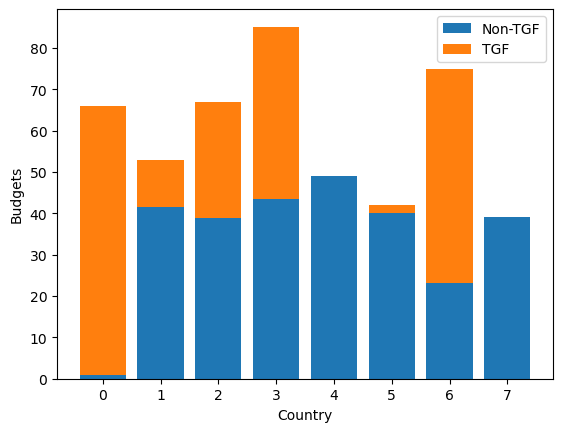

In [6]:
# Non_TGF Budget + TGF Allocation as stacked bars:
fig, ax = plt.subplots()
ax.bar(np.arange(num_countries), non_tgf_budget_by_country, label='Non-TGF')
ax.bar(np.arange(num_countries), tgf_allocation_by_country, bottom=non_tgf_budget_by_country, label='TGF')
plt.xlabel('Country')
plt.ylabel('Budgets')
plt.legend()
plt.show()

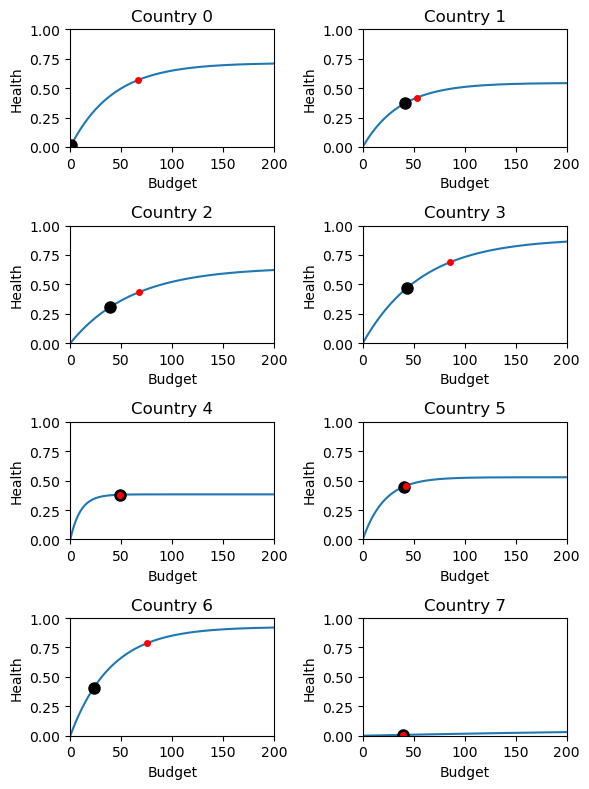

In [7]:
# Non_TGF Budget + TGF Allocation on the Health-Budget Graph 
# (Nb, Here we are plotting graphs with 'health' downwards, as if it's deaths etc, to match other graphics.)
fig, ax = plt.subplots(ncols=2, nrows=4)
fig.set_size_inches(6, 8)
for c, ax in enumerate(fig.axes):
    res = db.country_results[c]
    ax.plot(
        res.index, 
        res.values, 
        label=f"Health Gains"
    )
    ax.plot(
        non_tgf_budget_by_country[c], 
        db.get_results(c, non_tgf_budget_by_country[c]),
        'ko', markersize=8, label='Non-TGF'
    )
    ax.plot(
        non_tgf_budget_by_country[c] + tgf_allocation_by_country[c],
        db.get_results(c, non_tgf_budget_by_country[c] + tgf_allocation_by_country[c]),
        'r.', markersize=8, label='Non-TGF + TGF'
    )
    ax.set_xlabel('Budget')
    ax.set_xlim([0, 200])
    ax.set_ylim([0, 1.0])
    ax.set_title(f"Country {c}")
    ax.set_ylabel('Health')
plt.tight_layout()
plt.show()

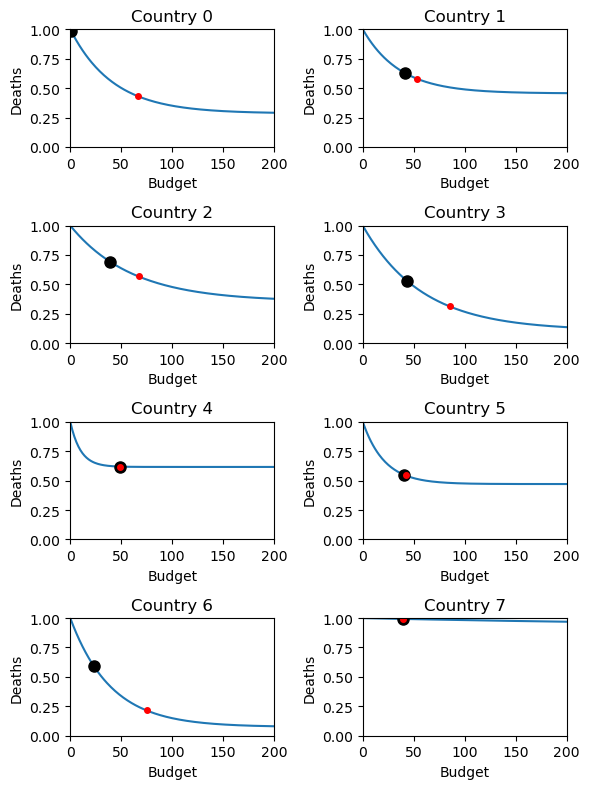

In [8]:
# (Here is the same plot but this time with 'health' downwards, as if it's deaths etc, to match other graphics.)
fig, ax = plt.subplots(ncols=2, nrows=4)
fig.set_size_inches(6, 8)
for c, ax in enumerate(fig.axes):
    res = db.country_results[c]
    ax.plot(
        res.index, 
        1.0 - res.values, 
        label=f"Health Gains"
    )
    ax.plot(
        non_tgf_budget_by_country[c], 
        1.0 - db.get_results(c, non_tgf_budget_by_country[c]),
        'ko', markersize=8, label='Non-TGF'
    )
    ax.plot(
        non_tgf_budget_by_country[c] + tgf_allocation_by_country[c],
        1.0 - db.get_results(c, non_tgf_budget_by_country[c] + tgf_allocation_by_country[c]),
        'r.', markersize=8, label='Non-TGF + TGF'
    )
    ax.set_xlabel('Budget')
    ax.set_xlim([0, 200])
    ax.set_ylim([0, 1.0])
    ax.set_title(f"Country {c}")
    ax.set_ylabel('Deaths')
plt.tight_layout()
plt.show()

We observe in the results that the greatest amounts of TGF allocation have gone to:

countries in which there is a low initial allocation from non-TGF sources;
countries in which there is a high rate of return in health-gains

### Checking

As a check, we do the optimisation using a standard numerical optimizer and check that it comes to the same result. Here we use a multi-variable local minimizer. For real applications we would examine the use of global optimizers, use different starting condition etc, in order to feel confident that we have found a truly global optimum.

In [9]:
# Define the constraints and bounds:
# 1) total of the allocations to each country cannot exceed budget
constraint = LinearConstraint(np.ones(num_countries), lb=0.0, ub=tgf_budget)

# 2) Bounds on the allocation to each country to be non-zero:
bounds = np.array([(0, np.Inf) for c in range(num_countries)])

# Wrap the function `total_health_gains` because need to multiply the result by -1 (so that the minimum solution is the
# one we want) and also to pass in an additional argument.
to_minimize = lambda x: -1 * total_health_gain(x, non_tgf_budget_by_country)

# Run the minimization algorithm
sol = minimize(to_minimize,
               x0=np.array([0.0] * num_countries),  # <-- initial condition: zero tgf allocation (this can be changed)
               bounds=bounds,
               constraints=constraint,
               )

# Check the results against the constraints.
assert np.isclose(sum(sol.x), tgf_budget)
assert all([x >= 0 for x in sol.x])


# Compare solutions:

# Compare difference in health gain:
diff_in_health_gain = total_health_gain(
                          _tgf_allocation_by_country=tgf_allocation_by_country,
                          _non_tgf_budget_by_country=non_tgf_budget_by_country) \
                      - total_health_gain(
                          _tgf_allocation_by_country=sol.x,
                          _non_tgf_budget_by_country=non_tgf_budget_by_country)
print(diff_in_health_gain)

0.0010922272092930285


In [10]:
# Absolute difference:
print(np.round(tgf_allocation_by_country, 0) - np.round(sol.x, 0))

[-3. -2.  2.  4.  0.  1. -2.  0.]


In [11]:
# Percentage difference:
print(np.round(100 * (tgf_allocation_by_country - sol.x) / tgf_budget, 0))

[-1. -1.  1.  2. -0.  0. -1. -0.]


In [12]:
# Total difference in allocation:
print(np.round(100 * sum(np.abs(tgf_allocation_by_country - sol.x)) / tgf_budget, 0))

7.0
